# Kriging: Low-Rank Gaussian Process

## Setup and Imports

In [12]:
import jax.numpy as jnp
import liesel.goose as gs
import liesel.model as lsl
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd

import liesel_gam as gam

In [13]:
import jax

jax.config.update("jax_enable_x64", True)

In [14]:
df = gam.demo_data_ta(n=600, noise_sd=0.25, seed=42)
df_grid = gam.demo_data_ta(n=5000, grid=True)

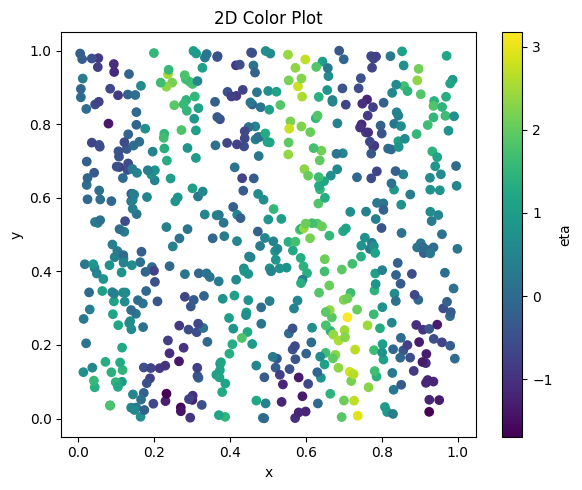

In [15]:
plt.figure(figsize=(6, 5))
plt.scatter(df["x"], df["y"], c=df["z"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

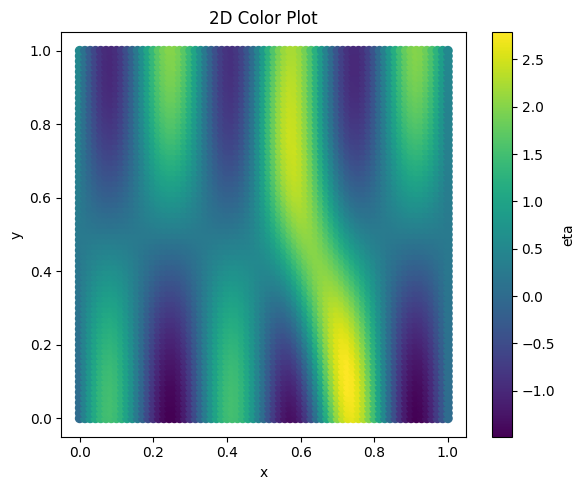

In [16]:
plt.figure(figsize=(6, 5))
plt.scatter(df_grid["x"], df_grid["y"], c=df_grid["eta"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Color Plot")
plt.colorbar(label="eta")
plt.tight_layout()
plt.show()

## Model Definition

### Setup response model

In [17]:
loc = gam.AdditivePredictor("$\\mu$")
scale = gam.AdditivePredictor("$\\sigma$", inv_link=jnp.exp)


z = lsl.Var.new_obs(
    value=df.z.to_numpy(),
    distribution=lsl.Dist(tfd.Normal, loc=loc, scale=scale),
    name="z",
)

In [18]:
tb = gam.TermBuilder.from_df(df)

In [19]:
loc += tb.kriging("x", "y", k=50, scale=gam.VarIGPrior(0.01, 0.01, 1.0))

### Build and plot model

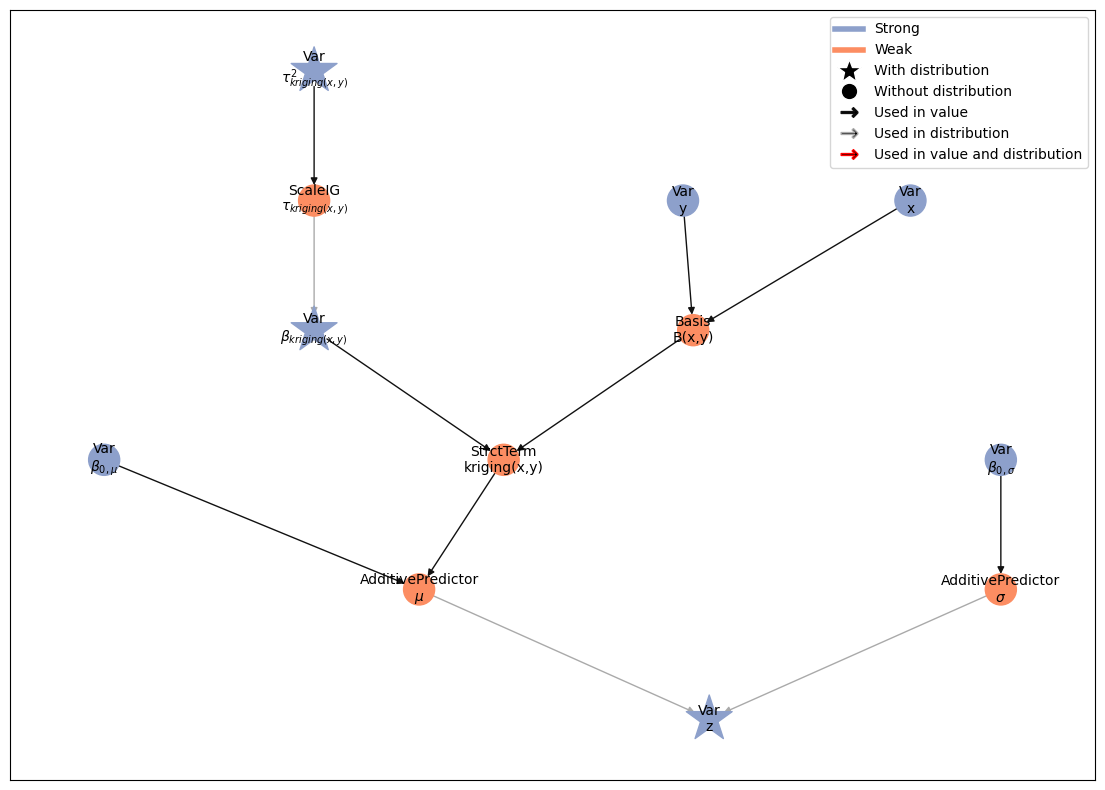

In [20]:
model = lsl.Model([z], to_float32=False)
model.plot_vars()

## Run MCMC

In [21]:
eb = gs.LieselMCMC(model).get_engine_builder(seed=1, num_chains=4)

eb.add_burnin(5_000)
eb.add_posterior(10_000, thinning=10)

engine = eb.build()
engine.sample_all_epochs()
results = engine.get_results()

liesel.goose.builder - WARNING - No jitter functions provided for position keys '$\\beta_{0,\\sigma}$', '$\\beta_{0,\\mu}$', '$\\beta_{kriging(x,y)}$', '$\\tau_{kriging(x,y)}^2$'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: BURNIN, 5000 transitions, 5000 jitted together
100%|██████████████████████████████████████████| 1/1 [00:02<00:00,  2.97s/chunk]
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Finished warmup
liesel.goose.engine - INFO - Starting epoch: POSTERIOR, 10000 transitions, 5000 jitted together
100%|██████████████████████████████████████████| 2/2 [00:05<00:00,  2.87s/chunk]
liesel.goose.engine - INFO - Finished epoch


### MCMC summary

In [22]:
summary = gs.Summary(results)

diagnostics = (
    summary.to_dataframe()
    .reset_index()
    .loc[:, ["variable", "rhat", "ess_bulk", "ess_tail"]]
    .groupby("variable", as_index=False)
    .agg(
        ess_bulk_min=("ess_bulk", "min"),
        ess_bulk_median=("ess_bulk", "median"),
        ess_tail_min=("ess_tail", "min"),
        ess_tail_median=("ess_tail", "median"),
        rhat_max=("rhat", "max"),
        rhat_median=("rhat", "median"),
    )
)
diagnostics

,variable,ess_bulk_min,ess_bulk_median,ess_tail_min,ess_tail_median,rhat_max,rhat_median
0,"$\beta_{0,\mu}$",3794.871268,3794.871268,4052.276456,4052.276456,1.000490,1.000490
1,"$\beta_{0,\sigma}$",3442.756741,3442.756741,3656.344183,3656.344183,1.000594,1.000594
2,"$\beta_{kriging(x,y)}$",2483.070736,2775.461849,2616.130260,3397.381375,1.002575,1.000604
3,"$\tau_{kriging(x,y)}^2$",3451.701135,3451.701135,3816.996345,3816.996345,1.000503,1.000503


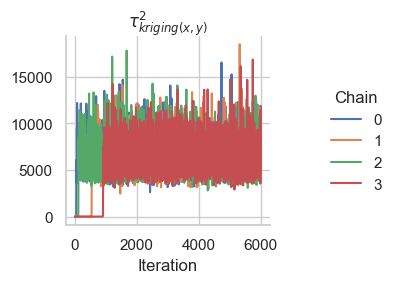

In [23]:
gs.plot_trace(results, [n for n in model.parameters if "tau" in n], include_warmup=True)

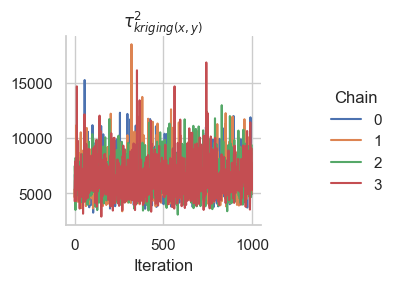

In [24]:
gs.plot_trace(
    results, [n for n in model.parameters if "tau" in n], include_warmup=False
)

In [25]:
samples = results.get_posterior_samples()

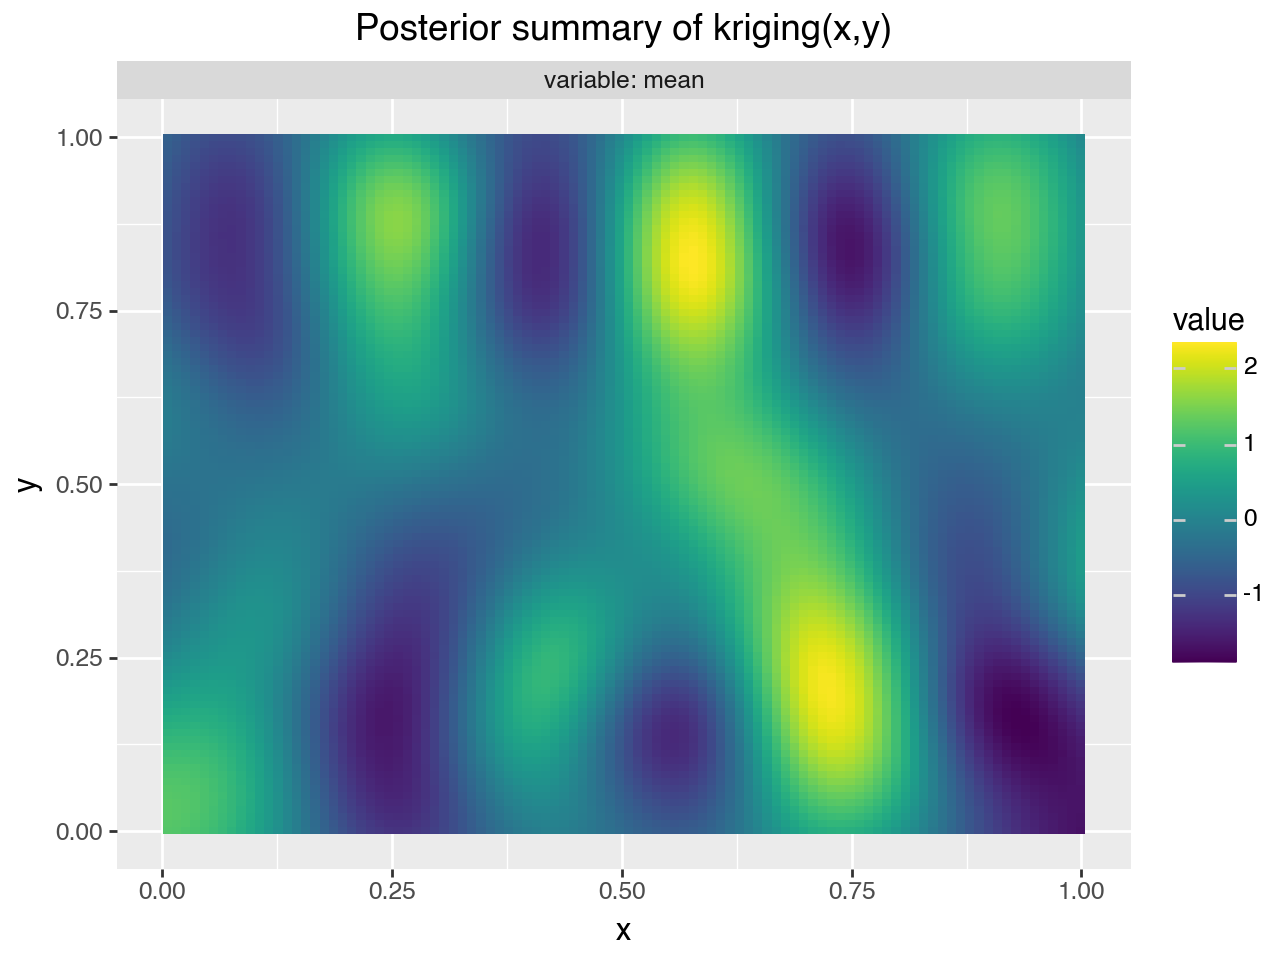

In [26]:
gam.plot_2d_smooth(model.vars["kriging(x,y)"], samples, ngrid=100)